# Resource project scheduling problems

In this notebook, we explore how to solve a resource constrained project scheduling problem (RCPSP).

The problem is made of $M$ activities that have precedence constraints. That means that if activity $j\in[1,M]$ is a successor of activity $i\in[1,M]$, then activity $i$ must be completed before activity $j$ can be started

On top of these constraints, each project is assigned a set of K renewable resources where each resource $k$ is available in $R_{k}$ units for the entire duration of the project. Each activity may require one or more of these resources to be completed. While scheduling the activities, the daily resource usage for resource $k$ can not exceed $R_{k}$ units.

Each activity $j$ takes $d_{j}$ time units to complete.

The overall goal of the problem is usually to minimize the makespan.

A classic variant of RCPSP is the multimode RCPSP where each task can be executed in several ways (one way=one mode). A typical example is :

Mode n°1 'Fast mode': high resource consumption and fast
Mode n°2 'Slow mode' : low resource consumption but slow

## A simple problem definition

Let start with a very simple problem which has only 5 tasks to execute:
All tasks have specific durations and they can consume 1 type of renewable resources.

Some tasks need to be executed after some have completed, for example:
 - Task 1 has 2 successors: task 2 and task 4
 - Task 2 has a single successor: Task 3
 - Task 3 and Task 4 have the same successor: Task 5
 - Task 5 has no successor
 
Task 0 & Task 5 have specific roles. The first one is called the source and the former the sink. They ususally have a zero duration.

In our problem, Tasks 2 & 3 have a duration of 3 while Task 4 has a duration of 7 units.

![image.png](images/sched.png)

In [88]:
# To load minizinc path etc.
import skdecide.hub

In [89]:
print(sys.path)

['/Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp', '/Users/poveda_g/opt/miniconda3/envs/isae_course/lib/python37.zip', '/Users/poveda_g/opt/miniconda3/envs/isae_course/lib/python3.7', '/Users/poveda_g/opt/miniconda3/envs/isae_course/lib/python3.7/lib-dynload', '', '/Users/poveda_g/opt/miniconda3/envs/isae_course/lib/python3.7/site-packages', '/Users/poveda_g/opt/miniconda3/envs/isae_course/lib/python3.7/site-packages/IPython/extensions', '/Users/poveda_g/.ipython', '/Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp/discrete_optimisation/', '/Users/poveda_g/Documents/cours_isae/seq_dec_mak/scheduling/rcpsp/discrete_optimisation/discrete_optimization/rcpsp/../']


In [90]:
import sys, os
this_folder = os.getcwd()
sys.path.append(os.path.join(this_folder, "discrete_optimisation/"))

# Missing installation

In [91]:
!pip install numba
!pip install sortedcontainers
!pip install shapely

## Loading the problems definition

In [92]:
from discrete_optimization.rcpsp.rcpsp_model import RCPSPModel, RCPSPSolution
from discrete_optimization.rcpsp.rcpsp_parser import files_available, parse_file

In [93]:
print([os.path.basename(f) for f in files_available])

['j601_7.sm', 'j601_3.sm', 'j301_4.sm', 'j1010_8.mm', 'j1010_10.mm', 'j1201_10.sm', 'j301_10.sm', 'j601_2.sm', 'j1010_9.mm', 'j301_5.sm', 'j601_6.sm', 'j301_1.sm', 'j1010_6.mm', 'j1201_1.sm', 'j1010_2.mm', 'j601_9.sm', 'j1201_5.sm', 'j1010_3.mm', 'j601_8.sm', 'j1201_4.sm', 'j1010_7.mm', 'j1201_7.sm', 'j301_8.sm', 'j1010_4.mm', 'j1201_3.sm', 'j1010_5.mm', 'j301_9.sm', 'j1201_2.sm', 'j1010_1.mm', 'j1201_6.sm', 'j601_1.sm', 'j301_6.sm', 'j1010_10_2.mm', 'j601_5.sm', 'j301_2.sm', 'j601_10.sm', 'j1201_9.sm', 'j601_4.sm', 'j301_3.sm', 'j1201_8.sm', 'j301_7.sm']


Now we can load some RCPSP problem from provided examples

In [94]:
file = [f for f in files_available if "j301_10.sm" in f][0]
model = parse_file(file)
print(model)

I'm a RCPSP model with 32 tasks.. and ressources =['R1', 'R2', 'R3', 'R4']


In [95]:
print(model, "\n", model.mode_details)

I'm a RCPSP model with 32 tasks.. and ressources =['R1', 'R2', 'R3', 'R4'] 
 {1: {1: {'duration': 0, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 0}}, 2: {1: {'duration': 4, 'R1': 1, 'R2': 0, 'R3': 0, 'R4': 0}}, 3: {1: {'duration': 3, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 2}}, 4: {1: {'duration': 10, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 4}}, 5: {1: {'duration': 10, 'R1': 0, 'R2': 0, 'R3': 1, 'R4': 0}}, 6: {1: {'duration': 5, 'R1': 0, 'R2': 10, 'R3': 0, 'R4': 0}}, 7: {1: {'duration': 1, 'R1': 0, 'R2': 3, 'R3': 0, 'R4': 0}}, 8: {1: {'duration': 7, 'R1': 3, 'R2': 0, 'R3': 0, 'R4': 0}}, 9: {1: {'duration': 4, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 1}}, 10: {1: {'duration': 5, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 6}}, 11: {1: {'duration': 7, 'R1': 0, 'R2': 0, 'R3': 0, 'R4': 6}}, 12: {1: {'duration': 10, 'R1': 0, 'R2': 3, 'R3': 0, 'R4': 0}}, 13: {1: {'duration': 2, 'R1': 0, 'R2': 7, 'R3': 0, 'R4': 0}}, 14: {1: {'duration': 4, 'R1': 0, 'R2': 0, 'R3': 2, 'R4': 0}}, 15: {1: {'duration': 5, 'R1': 0, 'R2': 5, 'R3': 0, 'R4': 0}

The problem includes 32 tasks and 4 ressources.
The precedence relations are stores in ``successors`` attributes : 

In [96]:
print(model.successors)

{1: [2, 3, 4], 2: [5, 7, 20], 3: [22], 4: [18], 5: [6, 9, 10], 6: [30], 7: [8, 11, 21], 8: [30], 9: [13, 14, 16], 10: [19], 11: [12], 12: [17, 25], 13: [21, 23], 14: [15, 27], 15: [28], 16: [29], 17: [24], 18: [19, 23], 19: [31], 20: [23], 21: [24], 22: [26, 27], 23: [26, 31], 24: [28], 25: [27, 28], 26: [30], 27: [31], 28: [29], 29: [32], 30: [32], 31: [32], 32: []}


Let's look at the precedence graph.

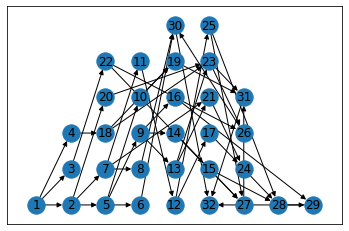

In [97]:
from discrete_optimization.generic_rcpsp_tools.graph_tools_rcpsp import build_graph_rcpsp_object
import networkx as nx
import matplotlib.pyplot as plt
graph = build_graph_rcpsp_object(model)
graph_nx = graph.graph_nx
dfs = nx.dfs_tree(G=graph_nx, source=1, depth_limit=10)
shortest_path_length = nx.shortest_path_length(dfs, 1)
length_to_nodes = {}
position = {}
for node in sorted(shortest_path_length, key=lambda x: shortest_path_length[x]):
    length = shortest_path_length[node]
    while not(length not in length_to_nodes or len(length_to_nodes[length]) <= 5):
        length += 1
    if length not in length_to_nodes:
        length_to_nodes[length] = []
    length_to_nodes[length] += [node]
    position[node] = (length, len(length_to_nodes[length]))
nx.draw_networkx(graph_nx, pos=position)
plt.show()

# Compute critical path

The critical path in project management is the longest path in the problem that can't be compressed, therefore it is a lower bound on the optimal makespan that is reachable. The critical path can be computed by a graph procedure described in https://www.youtube.com/watch?v=4oDLMs11Exs. and compute earliest start date.

In [98]:
from discrete_optimization.rcpsp.solver.cpm import CPM, CPMObject

In [99]:
CPM??

In [100]:
solver = CPM(rcpsp_model=model)
critical_path = solver.run_classic_cpm()
edges = [(pi, pi1) for pi, pi1 in zip(critical_path[:-1], critical_path[1:])]
print(solver.map_node[model.sink_task])

ModeOptim.MAXIMIZATION ObjectiveHandling.SINGLE ['makespan'] [-1]
{'_ESD': 37, '_EFD': 37, '_LSD': 37, '_LFD': 37}


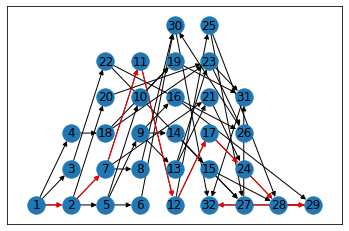

In [101]:
fig, ax = plt.subplots(1)
nx.draw_networkx(graph_nx, pos=position, ax=ax)
nx.draw_networkx_edges(graph_nx, pos=position, edgelist=edges, edge_color="r", ax=ax)

## Plotting a solution

In [102]:
some_solution = model.get_dummy_solution()

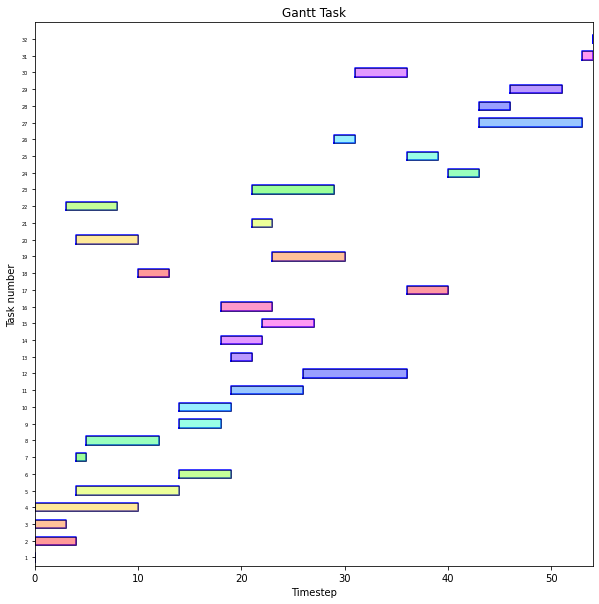

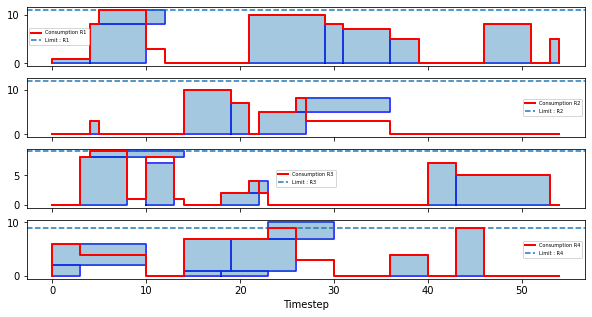

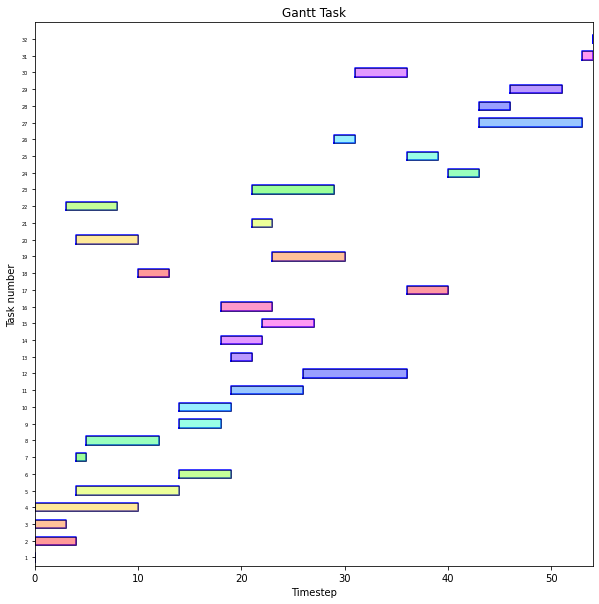

In [103]:
from discrete_optimization.rcpsp.rcpsp_utils import plot_ressource_view, plot_task_gantt
plot_ressource_view(model, some_solution)
plot_task_gantt(model, some_solution)

## SGS : Serial Generation Scheme


![image.png](images/sgs.png)

SGS algorithms is an procedure that aims at building *feasible* schedule from a permutation of task. The task are inserted in the priority order they are in the permutation list, as soon as possible.

## Exercise : 
code the SGS algorithm based on the previous algorithm !

In [104]:
import numpy as np
def sgs_algorithm(rcpsp_model: RCPSPModel, 
                  permutation_of_task: List[Hashable], predecessors=None):
    # Compute predecessors for each task. 
    if predecessors is None:
        predecessors = {k: set() for k in rcpsp_model.tasks_list}
        for k in rcpsp_model.successors:
            succ = rcpsp_model.successors[k]
            for s in succ:
                predecessors[s].add(k)
    # duration of the tasks.
    duration_task = {k: rcpsp_model.mode_details[k][1]["duration"] for k in rcpsp_model.mode_details}

    # Schedule to fill..
    schedule = {k: {"start_time": None,
                    "end_time": None}
                for k in rcpsp_model.tasks_list}
    
    
    resources_availability = {r: rcpsp_model.get_resource_availability_array(r) 
                              for r in rcpsp_model.resources_list}
    while True:
        # Select task to be scheduled at this round...
        # etc
        
        schedule[??]["start_time"] = ?
        schedule[??]["end_time"] = ?
    return schedule    

SyntaxError: invalid syntax (3900278024.py, line 26)

In [105]:
# %load correction/nb1_correction.py

In [106]:
tasks_list_permutation = list(model.tasks_list)
import random
random.shuffle(tasks_list_permutation)
schedule = sgs_algorithm(model, tasks_list_permutation)

## Bonus : code a Local search or Genetic algorithm using the SGS algorithms and the permutation encoding !

https://en.wikipedia.org/wiki/Simulated_annealing, https://en.wikipedia.org/wiki/Hill_climbing